In [13]:
import ssl
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=Warning)

set_config(transform_output = "pandas")

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv('https://raw.githubusercontent.com/ElieLECAS/ML_avance/fil_rouge/activite_finale/data/census_us.csv')
df.drop(['fnlwgt'], axis=1, inplace=True)
display(df.head(5))

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,<=50K
4,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,<=50K


In [14]:
print(f'nb dupe {df.loc[df.duplicated()].shape[0]}')
df = df.drop_duplicates(ignore_index=True)
df.describe()

nb dupe 6340


,age,capital_gain,capital_loss,hours_per_week
count,37492.000000,37492.000000,37492.000000,37492.000000
mean,39.644618,1257.112931,102.925024,40.702550
std,13.878898,7993.566016,434.941795,13.013938
min,17.000000,0.000000,0.000000,1.000000
25%,29.000000,0.000000,0.000000,38.000000
50%,38.000000,0.000000,0.000000,40.000000
75%,49.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


                                             |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



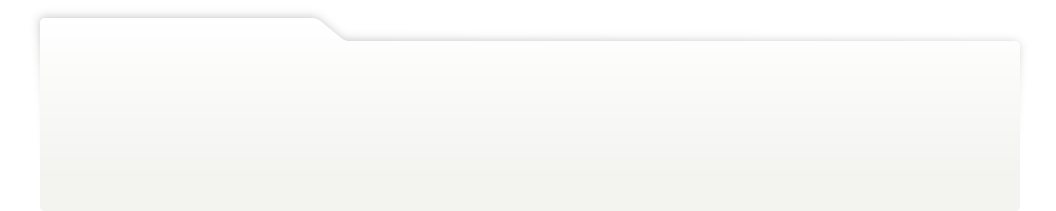
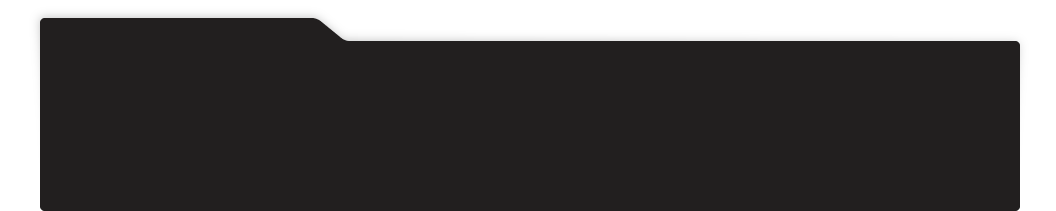
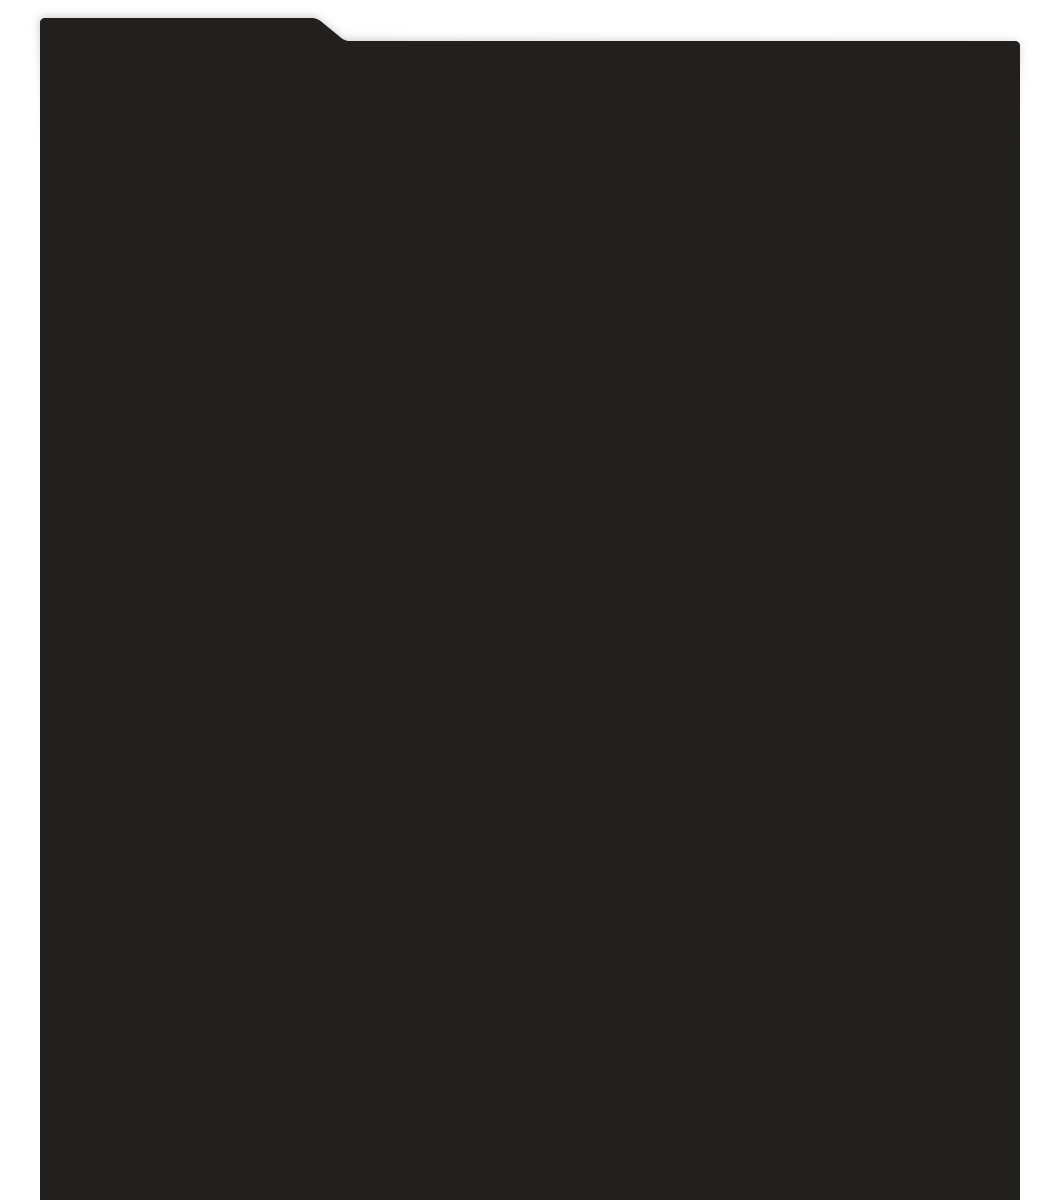
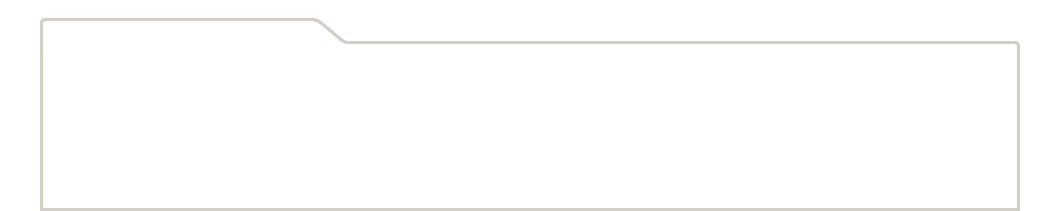
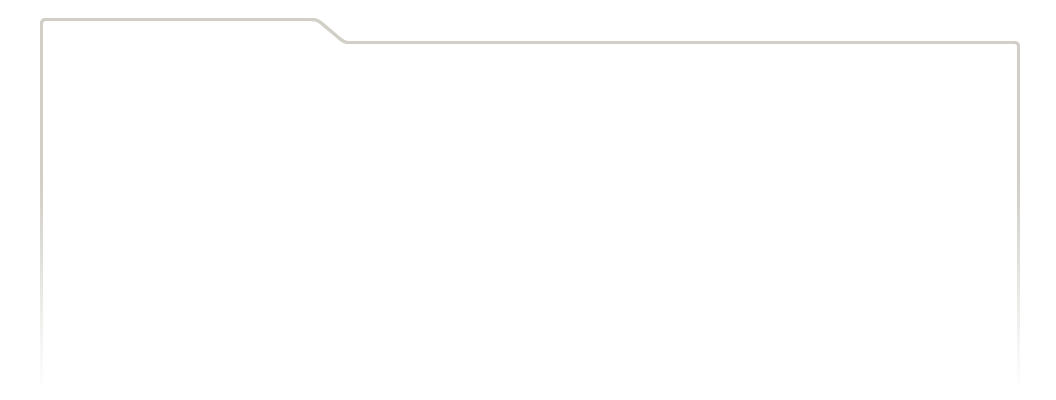
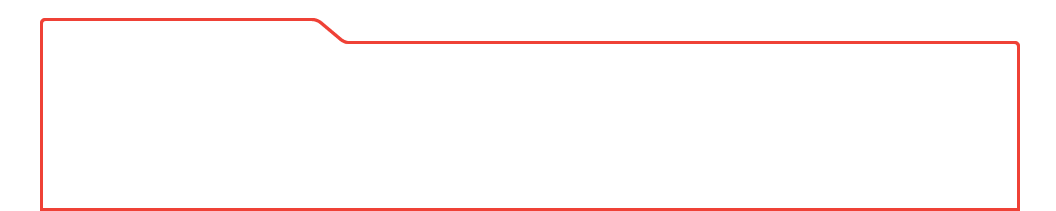
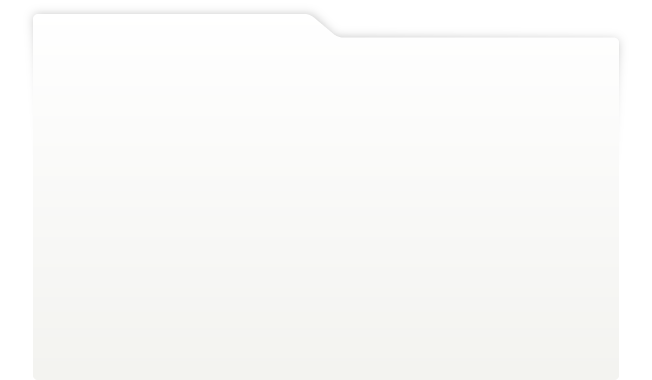
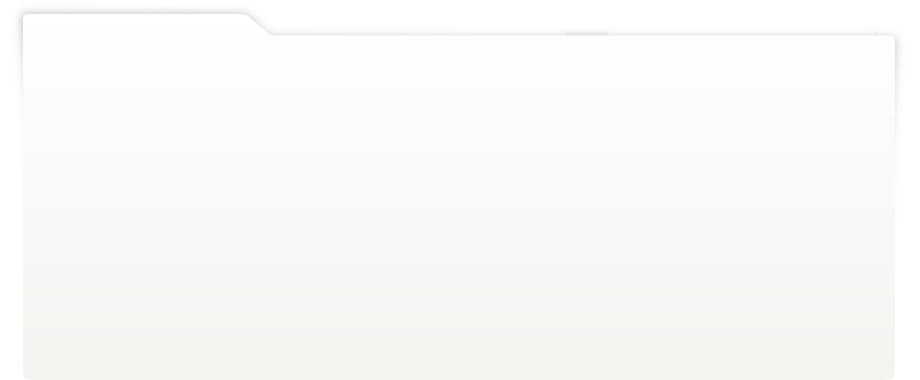
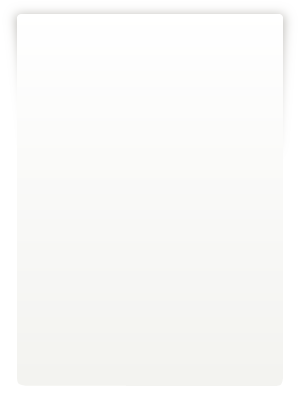
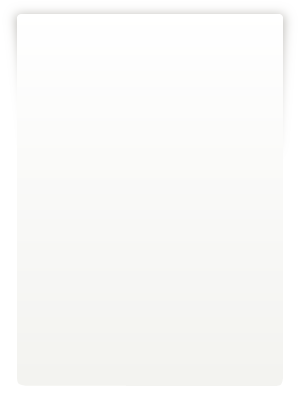
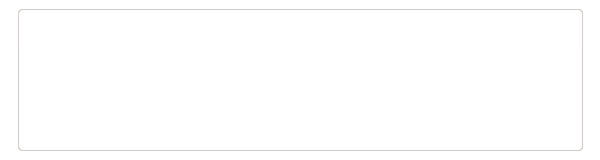
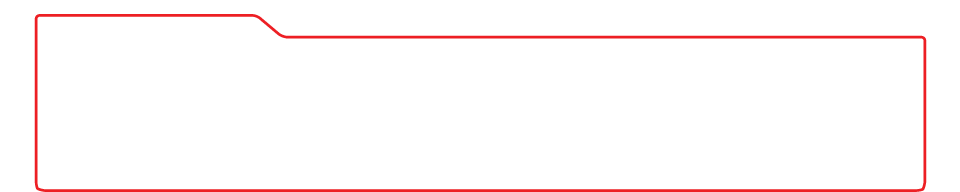
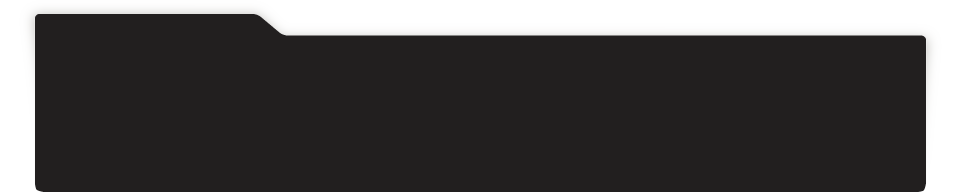
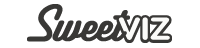
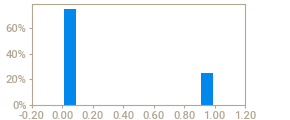
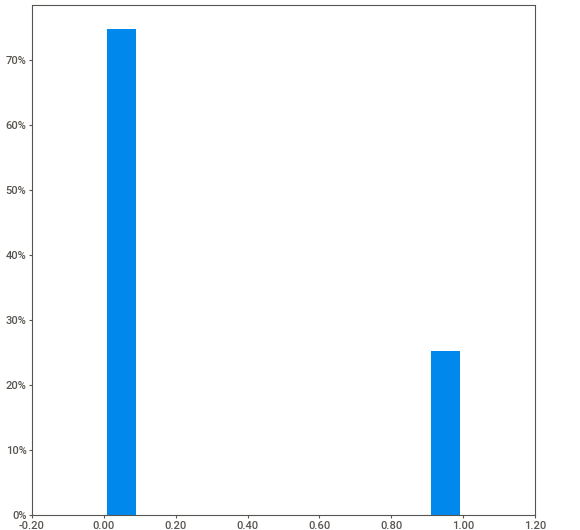
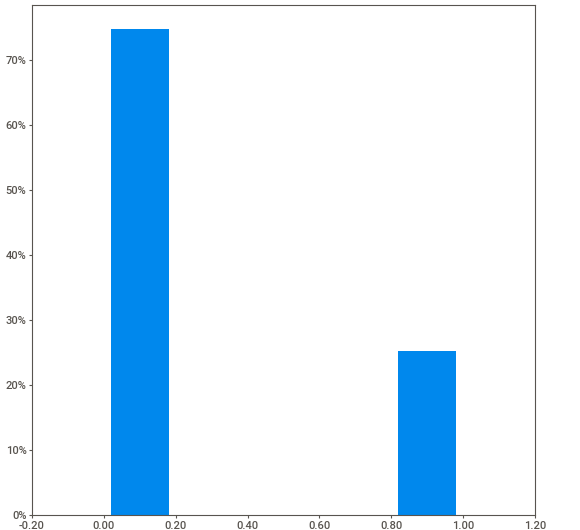
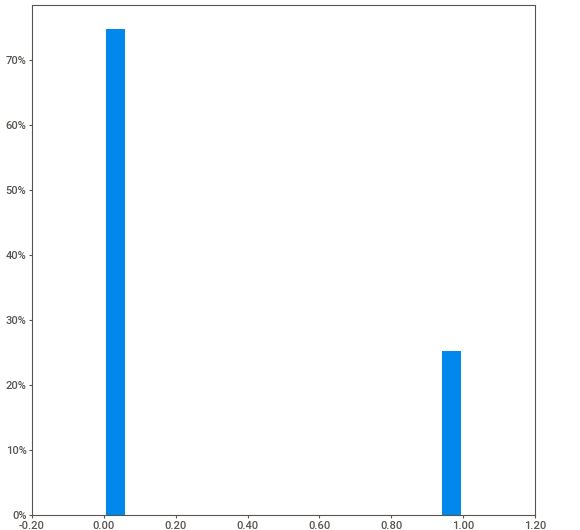
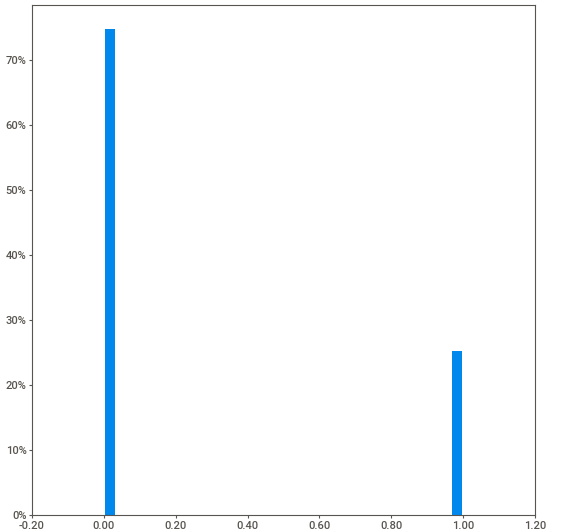
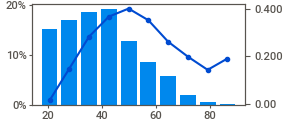
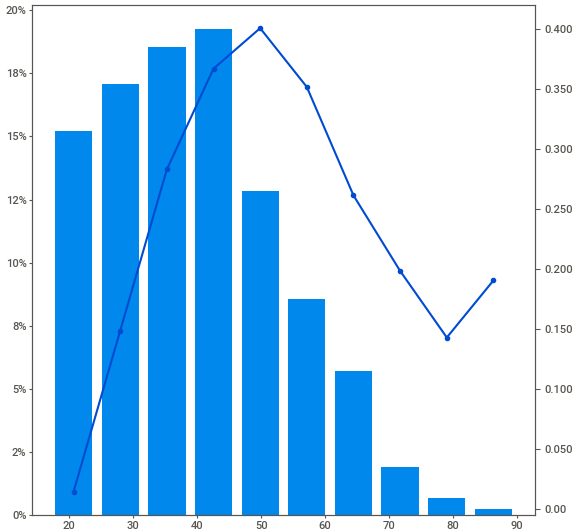
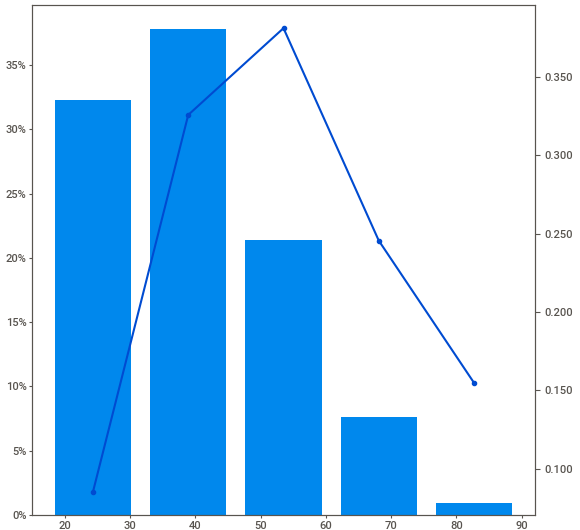
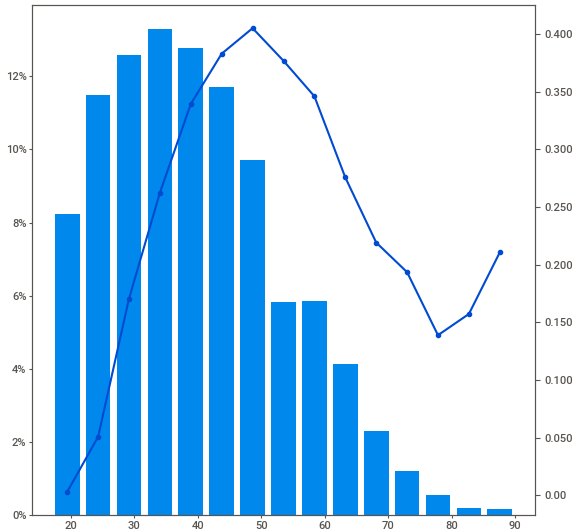
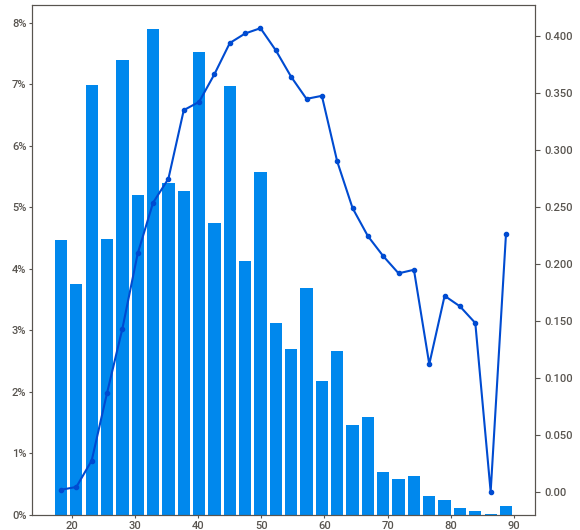
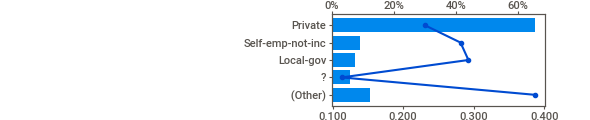
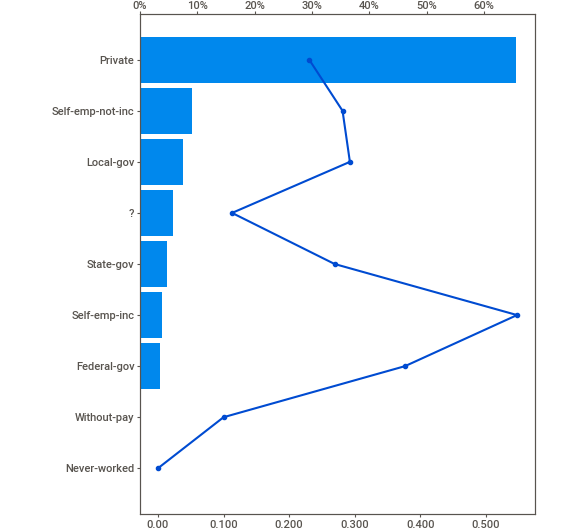
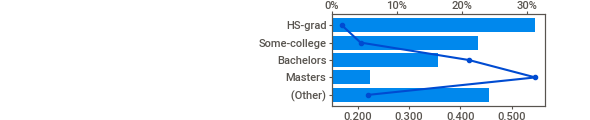
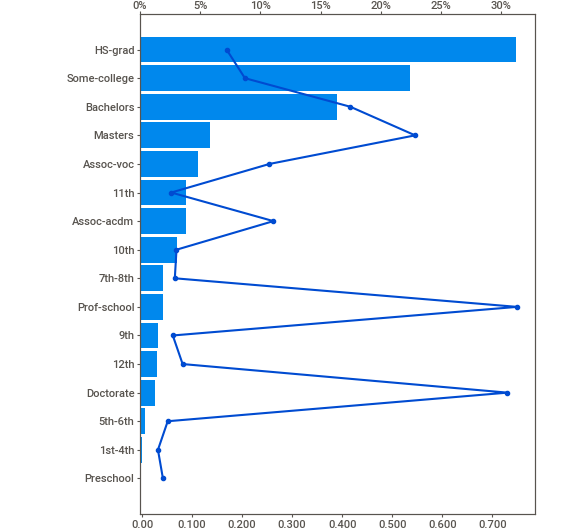
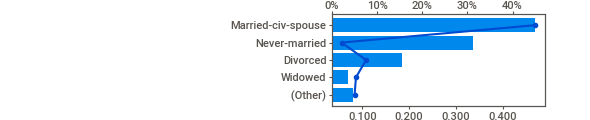
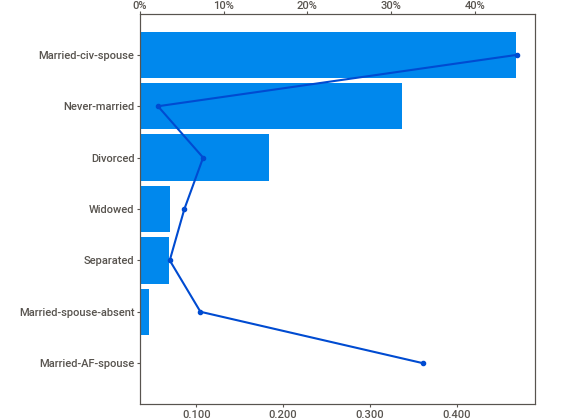
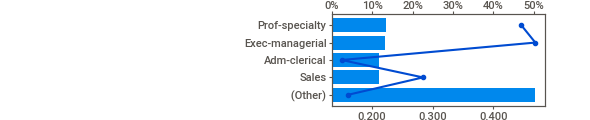
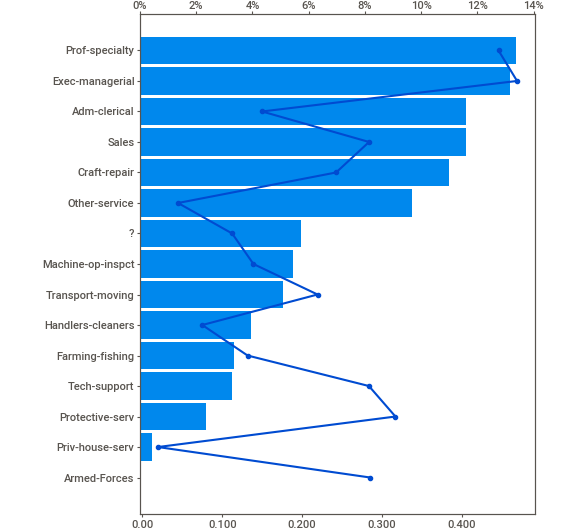
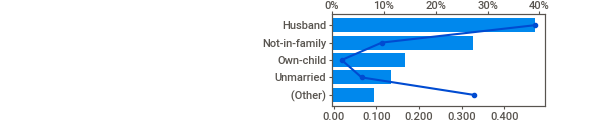
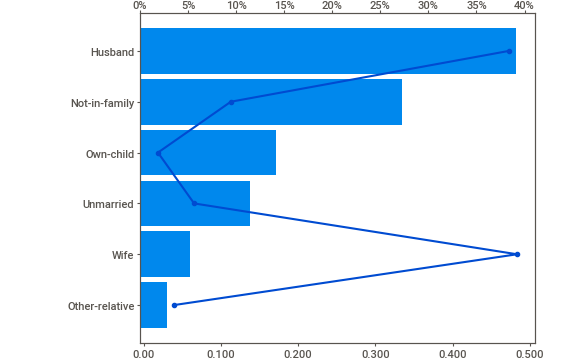
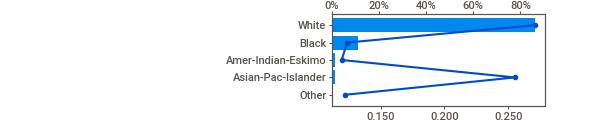
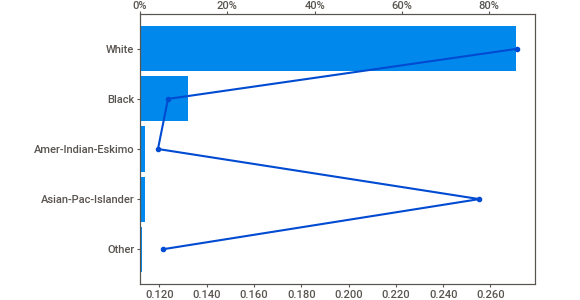
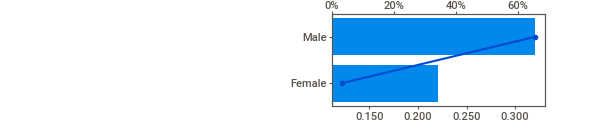
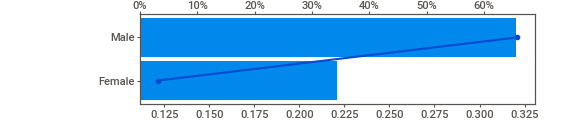
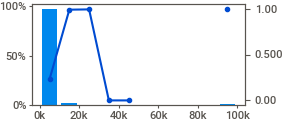
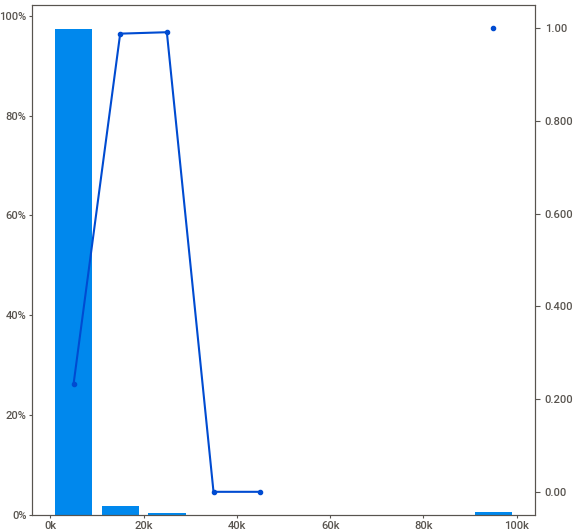
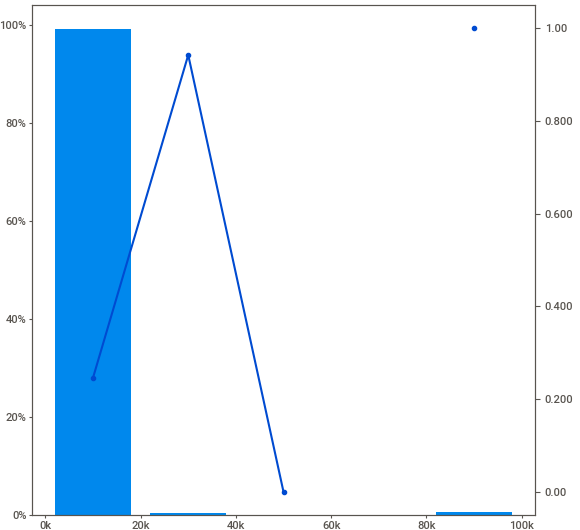
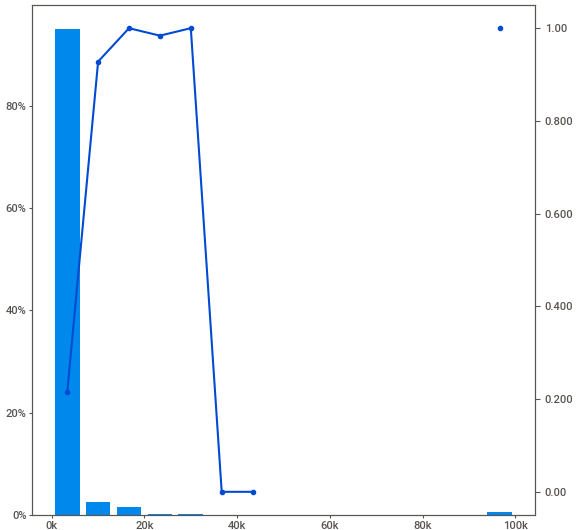
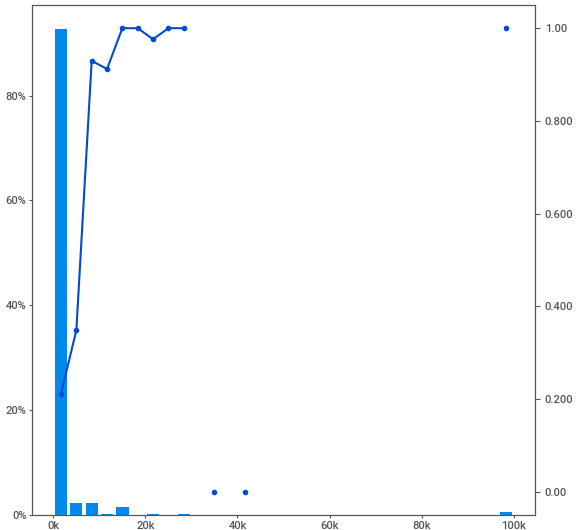
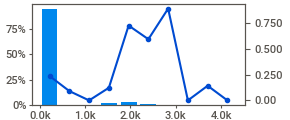
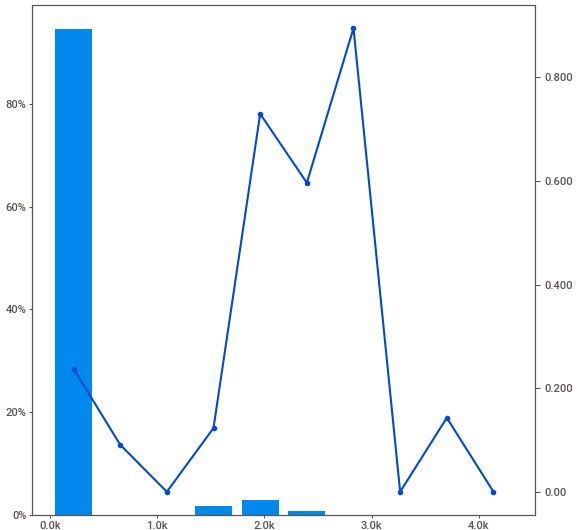
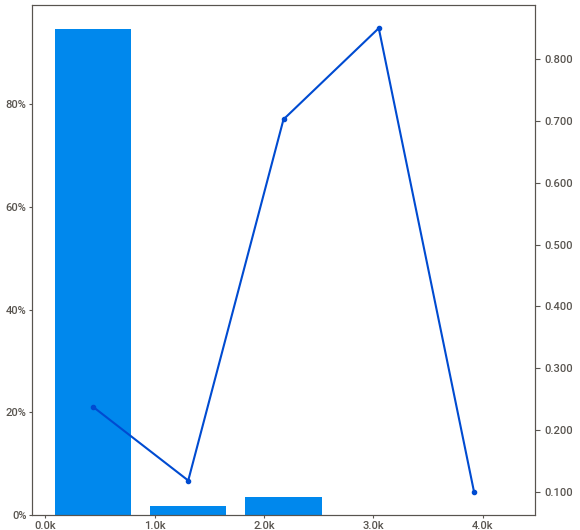
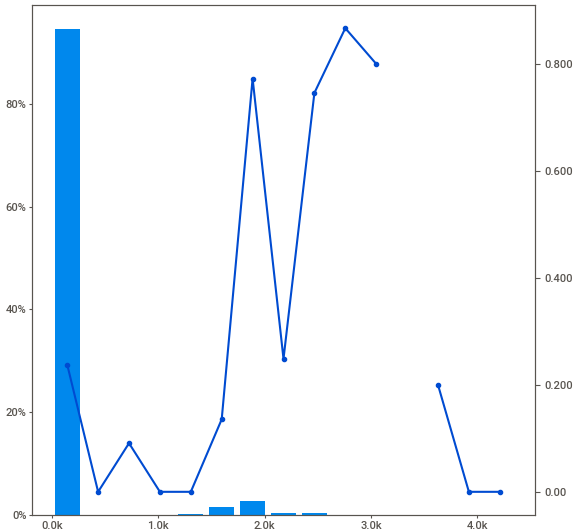
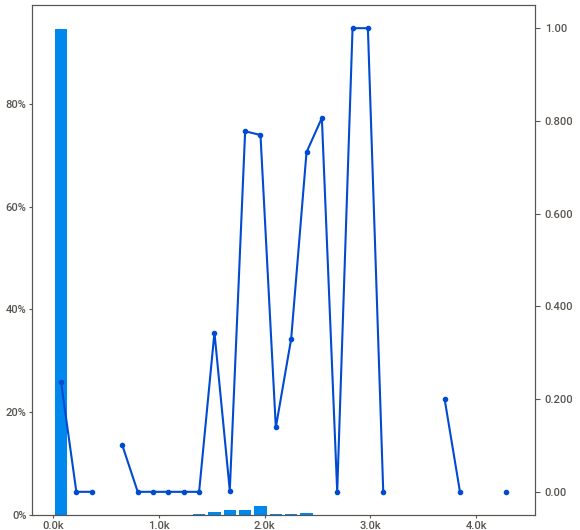
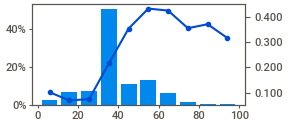
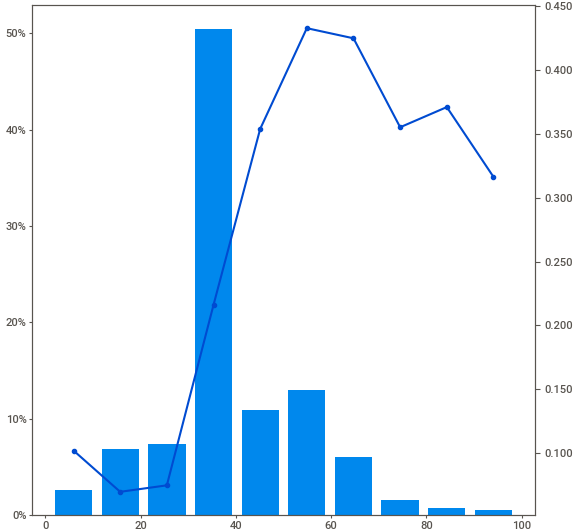
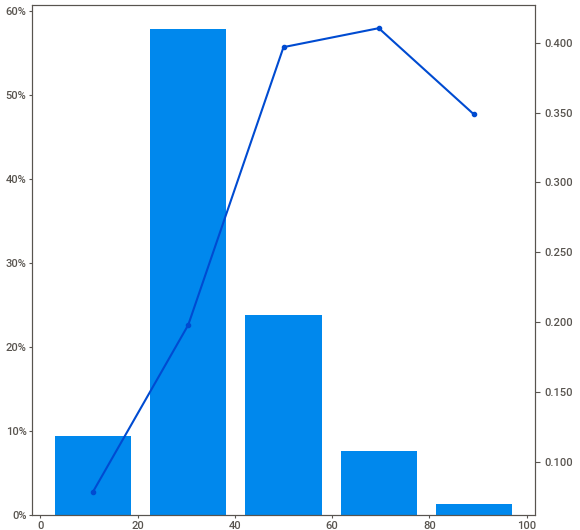
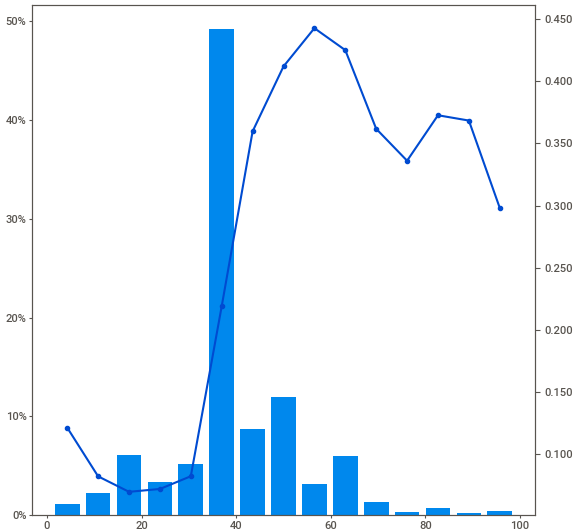
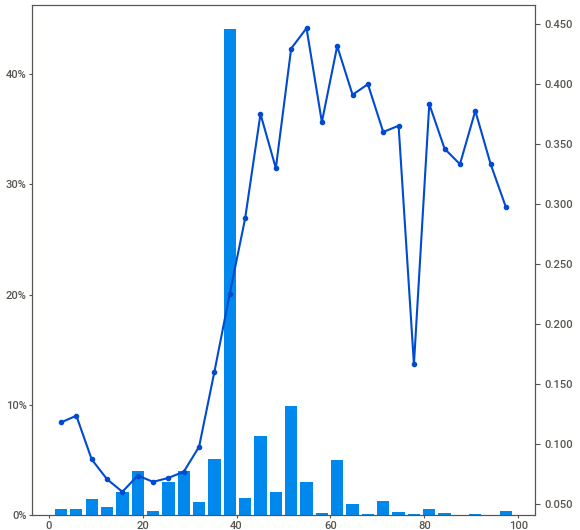
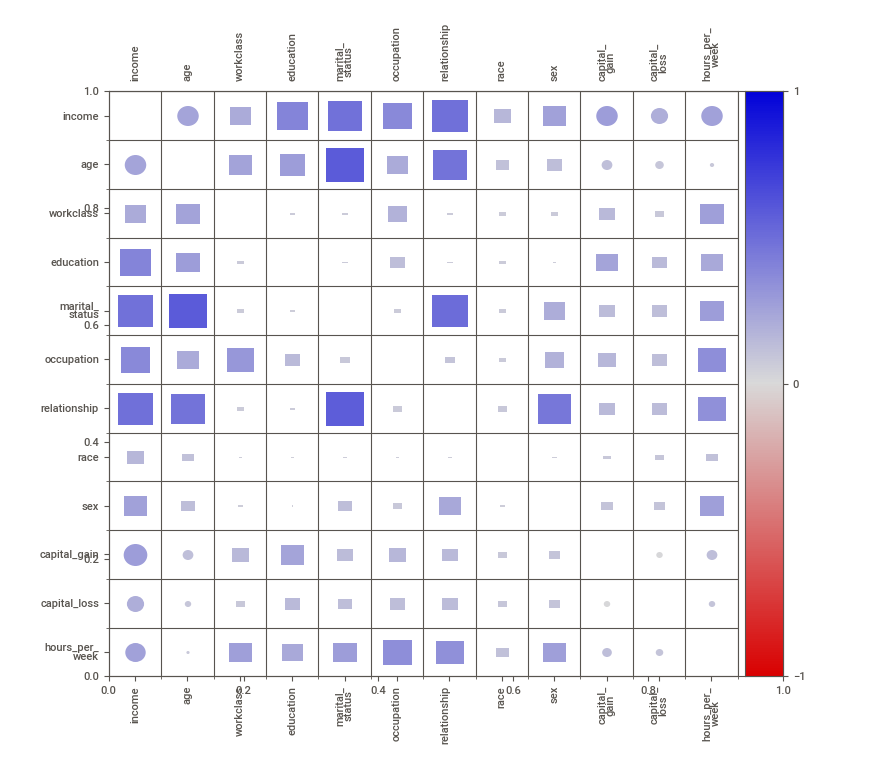
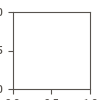

In [15]:
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
feature_config = sv.FeatureConfig(force_num=["income"])

df_viz = df.copy()
le = LabelEncoder()
df_viz['income'] = le.fit_transform(df_viz['income'])
df_viz['age'] = pd.to_numeric(df_viz['age'], errors='coerce')
df_viz['capital_gain'] = pd.to_numeric(df_viz['capital_gain'], errors='coerce')
df_viz['capital_loss'] = pd.to_numeric(df_viz['capital_loss'], errors='coerce')
df_viz['hours_per_week'] = pd.to_numeric(df_viz['hours_per_week'], errors='coerce')

sweet_report = sv.analyze(df_viz, 'income', feat_cfg=feature_config)
sweet_report.show_notebook()

# Modélisation

## Split

In [16]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85, shuffle=True)

## Encodage de la target (income)

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test  = le.fit_transform(y_test)
y_train = le.fit_transform(y_train)

## Création du pipeline

### Transformers

#### Education

In [18]:
from sklearn.preprocessing import OrdinalEncoder

df.education.value_counts()
# Créer un tableau de données contenant les niveaux d'éducation
data = [[
    "Preschool",
    "1st-4th grade",
    "5th-6th grade",
    "7th-8th grade",
    "9th grade",
    "10th grade",
    "11th grade",
    "12th grade",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
    "Prof-school"
]]

education_ordinal_encoder_column = ['education']

# Créer un ordinalencoder
education_ordinal_encoder = OrdinalEncoder(categories=data, handle_unknown='use_encoded_value', unknown_value=-1)

#### OHE

In [19]:
from sklearn.preprocessing import OneHotEncoder

binary_columns = ['sex']
nominal_columns = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']

binary_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
nominal_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transformers = ColumnTransformer(
    transformers=[
        ('education', education_ordinal_encoder, education_ordinal_encoder_column),
        ('binary var', binary_encoder, binary_columns),
        ('nominal var', nominal_encoder, nominal_columns),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

display(transformers)
X_transform = transformers.fit_transform(X_train, y_train)
display(X_transform.head())

ColumnTransformer(remainder='passthrough',
                  transformers=[('education',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th grade',
                                                             '5th-6th grade',
                                                             '7th-8th grade',
                                                             '9th grade',
                                                             '10th grade',
                                                             '11th grade',
                                                             '12th grade',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate',
                                                             'Prof-school']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['education']),
                                ('binary var',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('nominal var',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['workclass', 'marital_status', 'occupation',
                                  'relationship', 'race'])],
                  verbose_feature_names_out=False)

,education,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,age,capital_gain,capital_loss,hours_per_week
36449,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,20,0.0,0.0,40.0
32827,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,30,99999.0,0.0,40.0
34728,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,43,0.0,0.0,65.0
25226,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,38,0.0,0.0,55.0
17192,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,31,0.0,0.0,40.0


#### Préparation du scaler, de l'estimateur et de la feature selection

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold

variance_treshold = .0001
k = 25
kbest_test = chi2

feature_selection = make_pipeline(
            SelectKBest(kbest_test, k = k),
            VarianceThreshold(variance_treshold)
        )
scaler = MinMaxScaler()
estimator = GradientBoostingClassifier(max_depth=5, random_state=42)

### Test de performance

#### Sans feature selection

In [22]:
import time
from sklearn.metrics import classification_report

start = time.time()
pipe = make_pipeline(
            transformers,
            scaler,
            estimator)

pipe.fit(X_train, y_train)
stop = time.time()

print('Nb colonnes: ', len(pipe[:-1].fit_transform(X_train, y_train).columns))
print(f"Training time: {round(stop - start, 2)}s")

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

Nb colonnes:  43
Training time: 3.2s
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4195
           1       0.80      0.65      0.71      1429

    accuracy                           0.87      5624
   macro avg       0.84      0.80      0.81      5624
weighted avg       0.86      0.87      0.86      5624



#### Avec feature selection

In [23]:
start = time.time()
pipe = make_pipeline(
            transformers,
            scaler,
            feature_selection,
            estimator)

pipe.fit(X_train, y_train)
stop = time.time()

print('Nb colonnes: ', len(pipe[:-1].fit_transform(X_train, y_train).columns))
print(f"Training time: {round(stop - start, 2)}s")

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

Nb colonnes:  25
Training time: 2.59s
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4195
           1       0.80      0.63      0.71      1429

    accuracy                           0.87      5624
   macro avg       0.84      0.79      0.81      5624
weighted avg       0.86      0.87      0.86      5624



## feature importance

In [24]:
X_train_transf = pipe[:-1].fit_transform(X_train, y_train)
feat_labels = X_train_transf.columns
feat_labels

Index(['education', 'sex_Male', 'workclass_Federal-gov',
       'workclass_Self-emp-inc', 'marital_status_Married-civ-spouse',
       'marital_status_Never-married', 'marital_status_Separated',
       'marital_status_Widowed', 'occupation_Adm-clerical',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Prof-specialty',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife',
       'race_Black', 'age', 'capital_gain', 'capital_loss', 'hours_per_week'],
      dtype='object')

In [25]:
f = pd.DataFrame({'features': np.array(list(feat_labels)), 'score': pipe.named_steps['gradientboostingclassifier'].feature_importances_})
f.sort_values(by=['score'], ascending=False, inplace=True)
f

,features,score
4,marital_status_Married-civ-spouse,0.389828
22,capital_gain,0.252264
0,education,0.136521
23,capital_loss,0.082050
21,age,0.052014
24,hours_per_week,0.037524
9,occupation_Exec-managerial,0.012535
10,occupation_Farming-fishing,0.007481
13,occupation_Other-service,0.006151
14,occupation_Prof-specialty,0.004876
